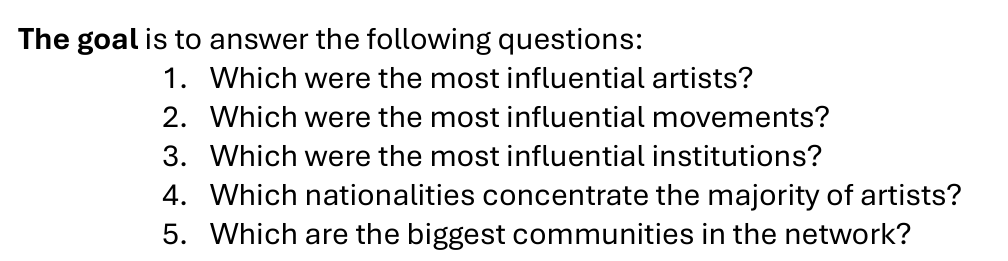

In [ ]:
import csv
import networkx as nx
from networkx.algorithms import community
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install pyvis
from pyvis.network import Network
import seaborn as sns
from IPython.core.display import display, HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
artists = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MiniProject3_data/artists.csv')
relationships = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MiniProject3_data/relationships.csv')
institutions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MiniProject3_data/institutions.csv')
schools = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MiniProject3_data/schools.csv')

# Clean Cleaning & Preprocessing

In [ ]:
# artists.shape
artists['artistUrl'] = artists['artistUrl'].apply(lambda x: x.split('/')[-1])
artists.head()

,artistUrl,id,image,nation,title,totalWorksTitle,year
0,ancient-egyptian-painting,5d230b31edc2c9fb74ae130a,https://uploads2.wikiart.org/00244/images/anci...,Egyptians,Ancient Egypt,169 artworks,c.3150 BC - c.640 AD
1,ancient-greek-pottery,5ced09b1edc2c993247c1ea0,https://uploads7.wikiart.org/00238/images/anci...,Greeks,Ancient Greek Pottery,87 artworks,c.900 - 31 BC
2,ancient-greek-painting,5ce3c54dedc2c921c4035b7d,https://uploads8.wikiart.org/00237/images/anci...,Greeks,Ancient Greek Painting and Sculpture,76 artworks,c.700 - c.31 BC
3,apelles,5ba232ccedc2c918cc654ea8,https://uploads2.wikiart.org/00202/images/apel...,Greek,Apelles,8 artworks,born c.370 BC
4,fayum-portrait,5beea1ededc2c915a01acdda,https://uploads7.wikiart.org/00210/images//01....,Egyptians,Fayum portrait,76 artworks,c.50 - c.250


In [ ]:
# relationships.shape
relationships['artistUrl'] = relationships['artistUrl'].apply(lambda x: x.split('/')[-1])
relationships['school'] = relationships['school'].apply(lambda x: x.split('/')[-1] if pd.notnull(x) else x)
relationships['institution'] = relationships['institution'].apply(lambda x: x.split('/')[-1] if pd.notnull(x) else x)
relationships['influenced_by'] = (
    relationships['influenced_by']
    .str.replace(r'/[^,]+/', '', regex=True)
    .str.replace(r'^\s+', '', regex=True)
)

relationships['influenced_on'] = (
    relationships['influenced_on']
    .str.replace(r'/[^,]+/', '', regex=True)
    .str.replace(r'^\s+', '', regex=True)
)
relationships['friends'] = (
    relationships['friends']
    .str.replace(r'/[^,]+/', '', regex=True)
    .str.replace(r'^\s+', '', regex=True)
)
relationships.head()


,artistUrl,friends,influenced_by,influenced_on,institution,movements,school,type
0,apelles,NaN,ancient-greek-painting,ancient-greek-painting,NaN,"Classical Period (480 - 323 BC),Hellenistic Pe...",sicyonian-school,Artists
1,wang-wei,NaN,NaN,NaN,NaN,Tang Dynasty (618–907),NaN,Artists
2,ancient-egyptian-painting,NaN,NaN,"fayum-portrait,ancient-greek-painting,ancient-...",NaN,"Early Dynastic Period (3150 – 2686 BC),Old Kin...",NaN,Collections
3,guanxiu,NaN,NaN,NaN,NaN,"Tang Dynasty (618–907),Five Dynasties and Ten ...",NaN,Artists
4,han-gan,NaN,NaN,NaN,NaN,Tang Dynasty (618–907),NaN,Artists


In [ ]:
institutions['url'] = institutions['url'].apply(lambda x: x.split('/')[-1] if pd.notnull(x) else x)
institutions.head()

,city,country,title,url
0,NaN,NaN,Guild of Saint Luke,guild-of-saint-luke
1,Antwerp,Belgium,Royal Academy of Fine Arts,royal-academy-of-fine-arts-antwerp-belgium
2,Munich,Germany,Akademie der Bildenden Künste München (Munich ...,akademie-der
3,Milan,Italy,Accademia di Belle Arti di Brera (Brera Academy),accademia-di-belle-arti-di-brera-brera-academy
4,Paris,France,Académie des Beaux-Arts,acad-mie-des-beaux


In [ ]:
schools.shape
schools['url'] = schools['url'].apply(lambda x: x.split('/')[-1] if pd.notnull(x) else x)
schools.head()

,title,url
0,Flemish School,flemish-school
1,Sienese School,sienese-school
2,Umbrian school,umbrian-school
3,Florentine School,florentine-school
4,Parma school,parma-school


In [ ]:
#print null or empty values count in artists.csv
print("Artists CSV-------------------------------------------------")
print(artists.isnull().sum())
print("Relationships CSV------------------------------------------------")
print(relationships.isnull().sum())
print("Institutions CSV------------------------------------------------")
print(institutions.isnull().sum())
print("Schools CSV------------------------------------------------")
print(schools.isnull().sum())

Artists CSV-------------------------------------------------
artistUrl           0
id                  0
image               0
nation             32
title               0
totalWorksTitle     0
year                1
dtype: int64
Relationships CSV------------------------------------------------
artistUrl           0
friends          2580
influenced_by    2512
influenced_on    2637
institution      2362
movements          40
school           1966
type                1
dtype: int64
Institutions CSV------------------------------------------------
city       2
country    2
title      0
url        0
dtype: int64
Schools CSV------------------------------------------------
title    0
url      0
dtype: int64


# Graph creation

In [ ]:
G = nx.DiGraph()

for _, row in artists.iterrows():
    G.add_node(row['artistUrl'], type='artist')

# Add Relationships
for _, row in relationships.iterrows():
    artist_url = row['artistUrl']

   # Add friends as edges (if any friends are listed)
    if pd.notnull(row['friends']):
        friends = row['friends'].split(',')  # Assuming friends are comma-separated
        for friend in friends:
            G.add_edge(artist_url, friend.strip(), relationship='friend')  # Trim any extra spaces

    # Add "influenced by" relationships as edges
    if pd.notnull(row['influenced_by']):
        influencers = row['influenced_by'].split(',')
        for influencer in influencers:
            G.add_edge(influencer.strip(),artist_url, relationship='influenced')

    # Add "influenced on" relationships as edges
    if pd.notnull(row['influenced_on']):
        influenced_artists = row['influenced_on'].split(',')
        for influenced in influenced_artists:
            G.add_edge(artist_url, influenced.strip(), relationship='influenced')

    # Add movements nodes & edges
    if pd.notna(row['movements']):
        movements = row['movements'].split(',')  # Assuming friends are comma-separated
        for movement in movements:
          G.add_node(movement, type='movement')
          G.add_edge(artist_url, movement, relationship='movement')

    # Add institutions nodes & edges
    if pd.notna(row['institution']):
        G.add_node(row['institution'], type='institution')
        G.add_edge(artist_url, row['institution'], relationship='institution')


# 1) Which were the most influential artists?

In [ ]:
#out degree
out_degree_specific = {}
for node in G.nodes(data=True):
    count = 0
    for neighbor in G.successors(node[0]):
        relationship = G[node[0]][neighbor].get('relationship')
        if relationship == 'influenced':
            count += 1
    out_degree_specific[node[0]] = count
influential_artists_specific = sorted(out_degree_specific.items(), key=lambda x: x[1], reverse=True)


print(f"\nTop 10 Influential Artists by Out-Degree for influenced:")
for artist, degree in influential_artists_specific[:10]:
    print(f"{artist}: {degree}")

#create subgraph where relationship of edges = relationship
G_specific = G.edge_subgraph([(u, v) for u, v, data in G.edges(data=True) if data.get('relationship') == 'influenced'])

#degree centrality
artist_influence = nx.degree_centrality(G_specific)
top_artists_by_degree = sorted(artist_influence.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Influential Artists by Degree Centrality:")
for artist, centrality in top_artists_by_degree[:10]:
    print(f"{artist}: {centrality}")

#between centrality
artist_betweenness = nx.betweenness_centrality(G_specific)
top_artists_by_betweenness = sorted(artist_betweenness.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Influential Artists by Betweenness Centrality:")
for artist, centrality in top_artists_by_betweenness[:10]:
    print(f"{artist}: {centrality}")


Top 10 Influential Artists by Degree Centrality:
pablo-picasso: 0.05006257822277847
paul-cezanne: 0.03754693366708386
gustave-courbet: 0.03379224030037547
rembrandt: 0.03254067584480601
caravaggio: 0.028785982478097622
jackson-pollock: 0.028785982478097622
paul-gauguin: 0.02753441802252816
francis-bacon: 0.02753441802252816
vincent-van-gogh: 0.0262828535669587
titian: 0.0262828535669587

Top 10 Influential Artists by Betweenness Centrality:
paul-cezanne: 0.007471876663516721
pablo-picasso: 0.007423780451620355
eugene-delacroix: 0.005992206799761418
gustave-courbet: 0.005553857613415428
raphael: 0.004884636312088187
paul-gauguin: 0.004422132277287344
titian: 0.0043330427246448125
rembrandt: 0.003815136147152529
john-constable: 0.003450175845157026
vincent-van-gogh: 0.0033813569440078344

Top 10 Influential Artists by Out-Degree for influenced:
pablo-picasso: 25
paul-cezanne: 23
rembrandt: 21
caravaggio: 21
titian: 17
gustave-courbet: 17
nicolas-poussin: 16
diego-velazquez: 16
raphael: 

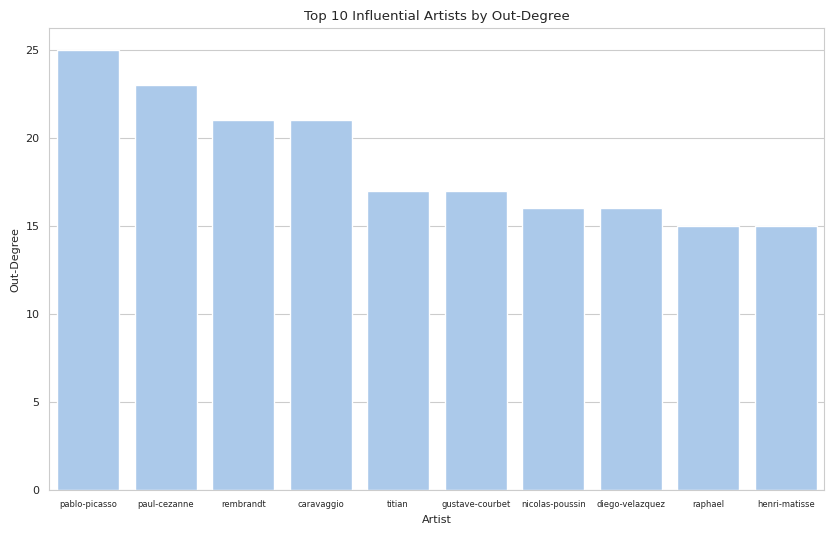

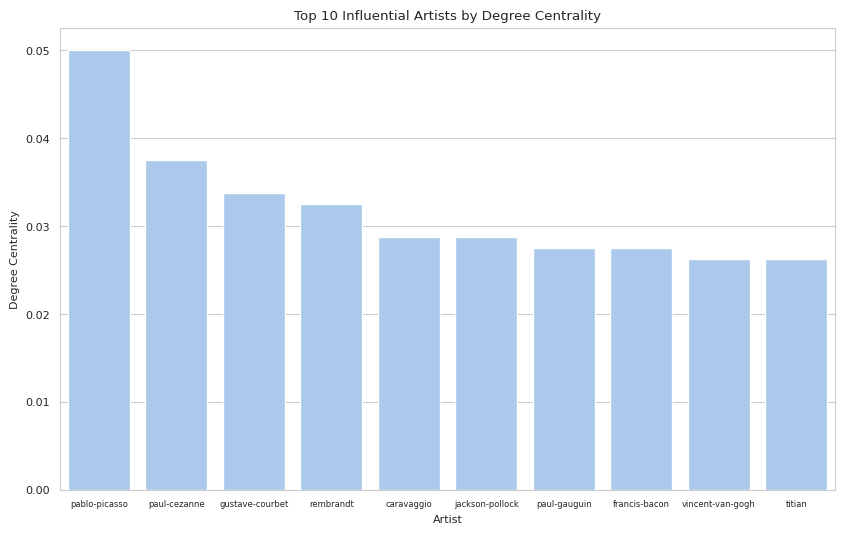

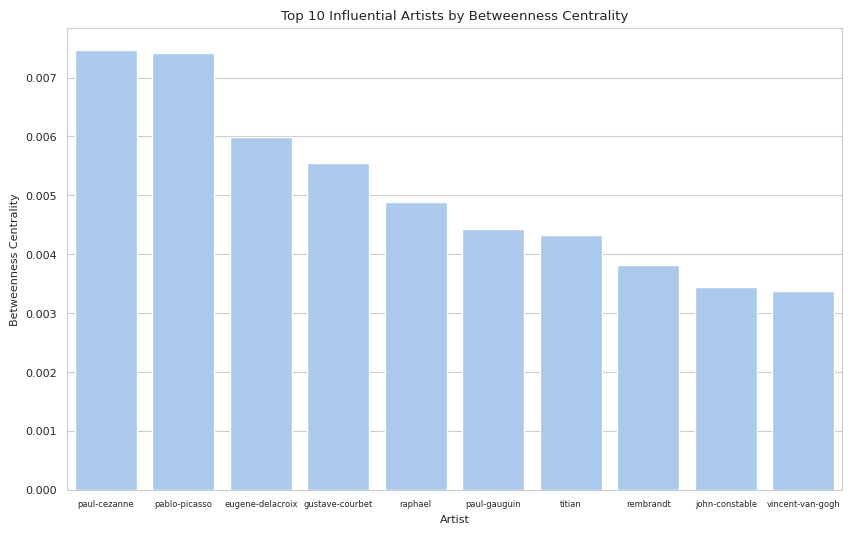

In [ ]:
#plot bar grph
influential_artists_specific_df = pd.DataFrame(influential_artists_specific[:10], columns=['Artist', 'Out-Degree'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Artist', y='Out-Degree', data=influential_artists_specific_df)
plt.xlabel('Artist')
plt.xticks(fontsize=6)
plt.ylabel('Out-Degree')
plt.title(f'Top 10 Influential Artists by Out-Degree')
plt.show()


top_artists_by_degree_df = pd.DataFrame(top_artists_by_degree[:10], columns=['Artist', 'Degree Centrality'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Artist', y='Degree Centrality', data=top_artists_by_degree_df)
plt.xlabel('Artist')
plt.xticks(fontsize=6)
plt.ylabel('Degree Centrality')
plt.title(f'Top 10 Influential Artists by Degree Centrality')
plt.show()

top_artists_by_betweenness_df = pd.DataFrame(top_artists_by_betweenness[:10], columns=['Artist', 'Betweenness Centrality'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Artist', y='Betweenness Centrality', data=top_artists_by_betweenness_df)
plt.xlabel('Artist')
plt.xticks(fontsize=6)
plt.ylabel('Betweenness Centrality')
plt.title(f'Top 10 Influential Artists by Betweenness Centrality')
plt.show()

# 2) Which were the most influential movements?

In [ ]:
movement_in_degree = {node: G.in_degree(node) for node, data in G.nodes(data=True) if data.get('type') == 'movement'}
influential_movements = sorted(movement_in_degree.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Influential Movements by In-Degree:")
for movement, degree in influential_movements[:10]:
    print(f"{movement}: {degree}")


movement_degree_centrality = {node for node, data in G.nodes(data=True) if data.get('type') != 'institution'}
# Calculate degree centrality for movements
movement_centrality = nx.degree_centrality(G.subgraph(movement_degree_centrality).to_undirected())
#filter movement_centrality with type as movement
movement_centrality = {k: v for k, v in movement_centrality.items() if G.nodes[k].get('type') == 'movement'}
top_movements = sorted(movement_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Influential Movements by Degree Centrality:")
for movement, centrality in top_movements[:10]:
    print(f"{movement}: {centrality}")


Top 10 Influential Movements by In-Degree:
Romanticism: 254
Impressionism: 209
Expressionism: 201
Realism: 192
Abstract Expressionism: 153
Surrealism: 152
Baroque: 145
Abstract Art: 143
Post-Impressionism: 130
Contemporary: 109

Top 10 Influential Movements by Degree Centrality:
Romanticism: 0.07625337736415491
Impressionism: 0.06274392074452116
Expressionism: 0.06034223956769739
Realism: 0.05764034824377064
Abstract Expressionism: 0.045932152506754725
Surrealism: 0.045631942359651755
Baroque: 0.04353047132993095
Abstract Art: 0.04293005103572501
Post-Impressionism: 0.03902731912338637
Contemporary: 0.03272290603422396


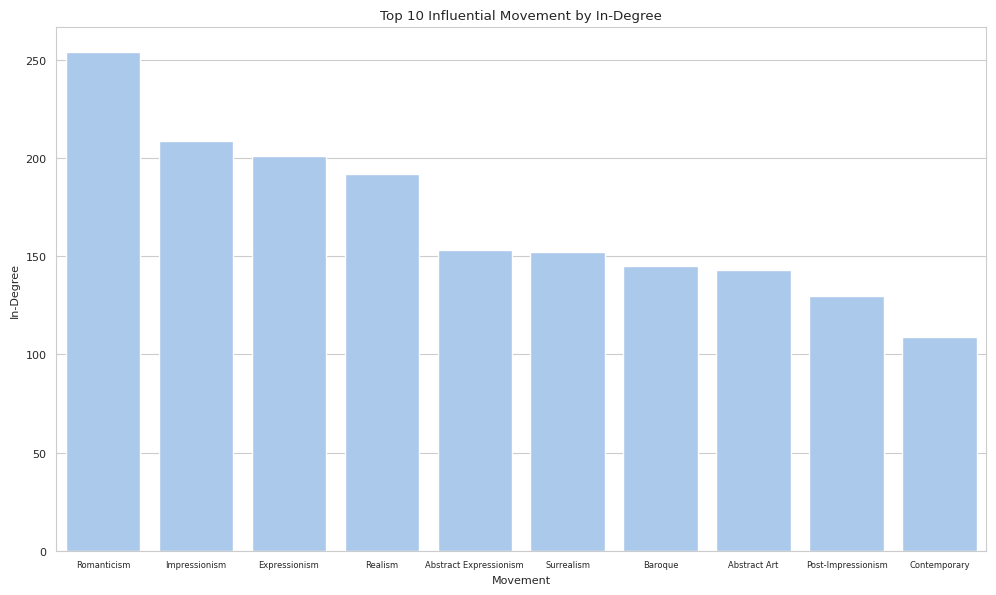

Text(0, 0.5, 'Degree Centrality')

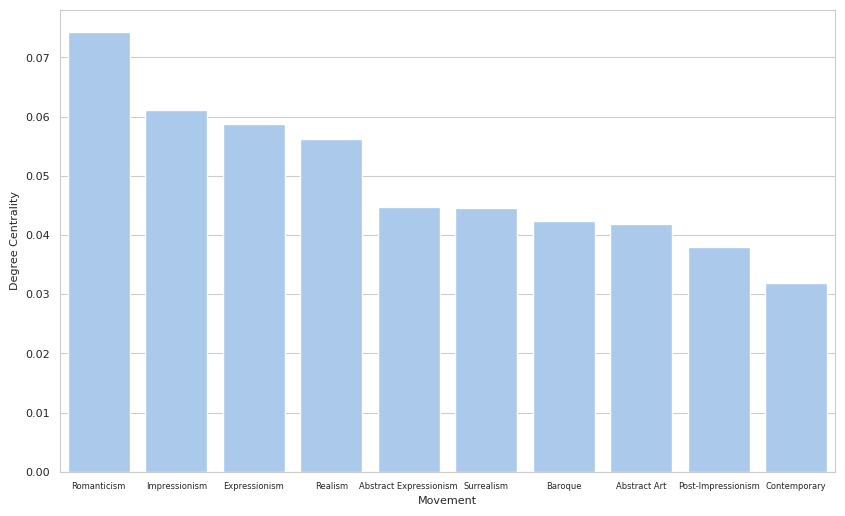

In [ ]:
influential_movements_specific_df = pd.DataFrame(influential_movements[:10], columns=['Movement', 'In-Degree'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Movement', y='In-Degree', data=influential_movements_specific_df)
plt.xlabel('Movement')
plt.ylabel('In-Degree')
plt.xticks(fontsize=6)
plt.title(f'Top 10 Influential Movement by In-Degree')
plt.tight_layout()
plt.show()

#plot by degree centality
top_movements_df = pd.DataFrame(top_movements[:10], columns=['Movement', 'Degree Centrality'])
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=6)
sns.barplot(x='Movement', y='Degree Centrality', data=top_movements_df)
plt.xlabel('Movement')
plt.ylabel('Degree Centrality')

# 3) Which were the most influential institutions?

In [ ]:
#3 Analyse in_degree for node type institution
institution_in_degree = {node: G.in_degree(node) for node, data in G.nodes(data=True) if data.get('type') == 'institution'}
influential_institutions = sorted(institution_in_degree.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Influential Institutions by In-Degree:")
for institution, degree in influential_institutions[:10]:
    print(f"{institution}: {degree}")

# Filter to institutions only
institutions_degree_centrality = {node for node, data in G.nodes(data=True) if data.get('type') != 'movement'}
# Calculate centrality for institutions
institution_centrality = nx.degree_centrality(G.subgraph(institutions_degree_centrality))
#filter institution_centrality with type as institution
institution_centrality = {k: v for k, v in institution_centrality.items() if G.nodes[k].get('type') == 'institution'}
top_institutions = sorted(institution_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Influential Institutions by Degree Centrality:")
for institution, centrality in top_institutions[:10]:
    print(f"{institution}: {centrality}")


Top 10 Influential Institutions by In-Degree:
cole-des-beaux-arts: 68
acad-mie-julian: 34
art-students-league: 33
guild-of-saint-luke: 30
imperial-academy-of-arts-saint-petersburg-russia: 29
royal-academy-of: 25
akademie-der: 24
national-academy-of-visual-arts-and-architecture: 23
self-taught: 18
kunstakademie-dusseldorf-dusseldorf-germany: 17

Top 10 Influential Institutions by Degree Centrality:
cole-des-beaux-arts: 0.020994133991972832
acad-mie-julian: 0.010497066995986416
art-students-league: 0.01018832973139858
guild-of-saint-luke: 0.009262117937635072
imperial-academy-of-arts-saint-petersburg-russia: 0.008953380673047236
royal-academy-of: 0.007718431614695894
akademie-der: 0.0074096943501080585
national-academy-of-visual-arts-and-architecture: 0.007100957085520223
self-taught: 0.005557270762581044
kunstakademie-dusseldorf-dusseldorf-germany: 0.005248533497993208


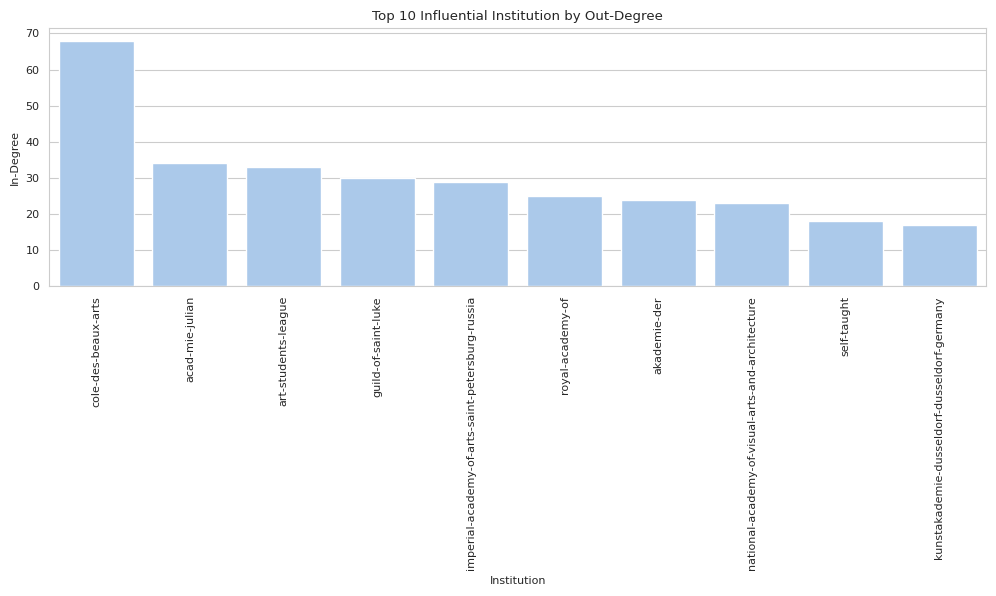

Text(0.5, 1.0, 'Top 10 Influential Institution by Degree Centrality')

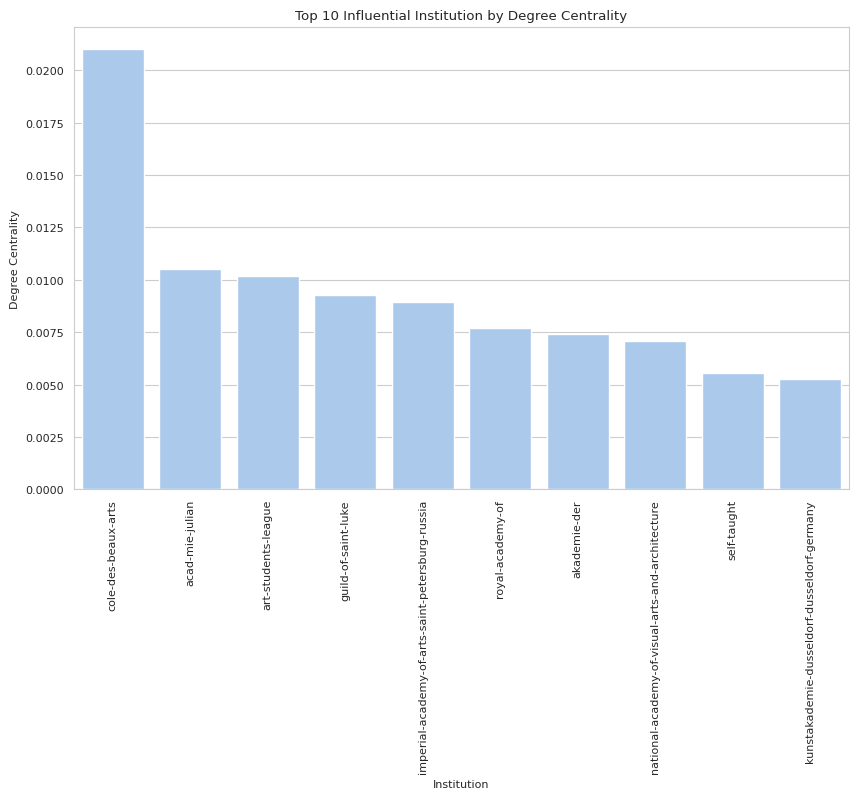

In [ ]:
#plot bar grph
influential_institutions_specific_df = pd.DataFrame(influential_institutions[:10], columns=['Institution', 'In-Degree'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Institution', y='In-Degree', data=influential_institutions_specific_df)
plt.xlabel('Institution')
plt.xticks(rotation=90)
plt.ylabel('In-Degree')
plt.title(f'Top 10 Influential Institution by Out-Degree')
plt.tight_layout()
plt.show()

#plot with centrality
top_institutions_df = pd.DataFrame(top_institutions[:10], columns=['Institution', 'Degree Centrality'])
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(x='Institution', y='Degree Centrality', data=top_institutions_df)
plt.xlabel('Institution')
plt.ylabel('Degree Centrality')
plt.title(f'Top 10 Influential Institution by Degree Centrality')

# 4) Which nationalities concentrate the majority of artists?

nation
American        520
French          402
Italian         269
British         249
German          160
               ... 
Italians          1
Bangladeshis      1
Romanians         1
Bosnian           1
Cameroonian       1
Name: count, Length: 106, dtype: int64


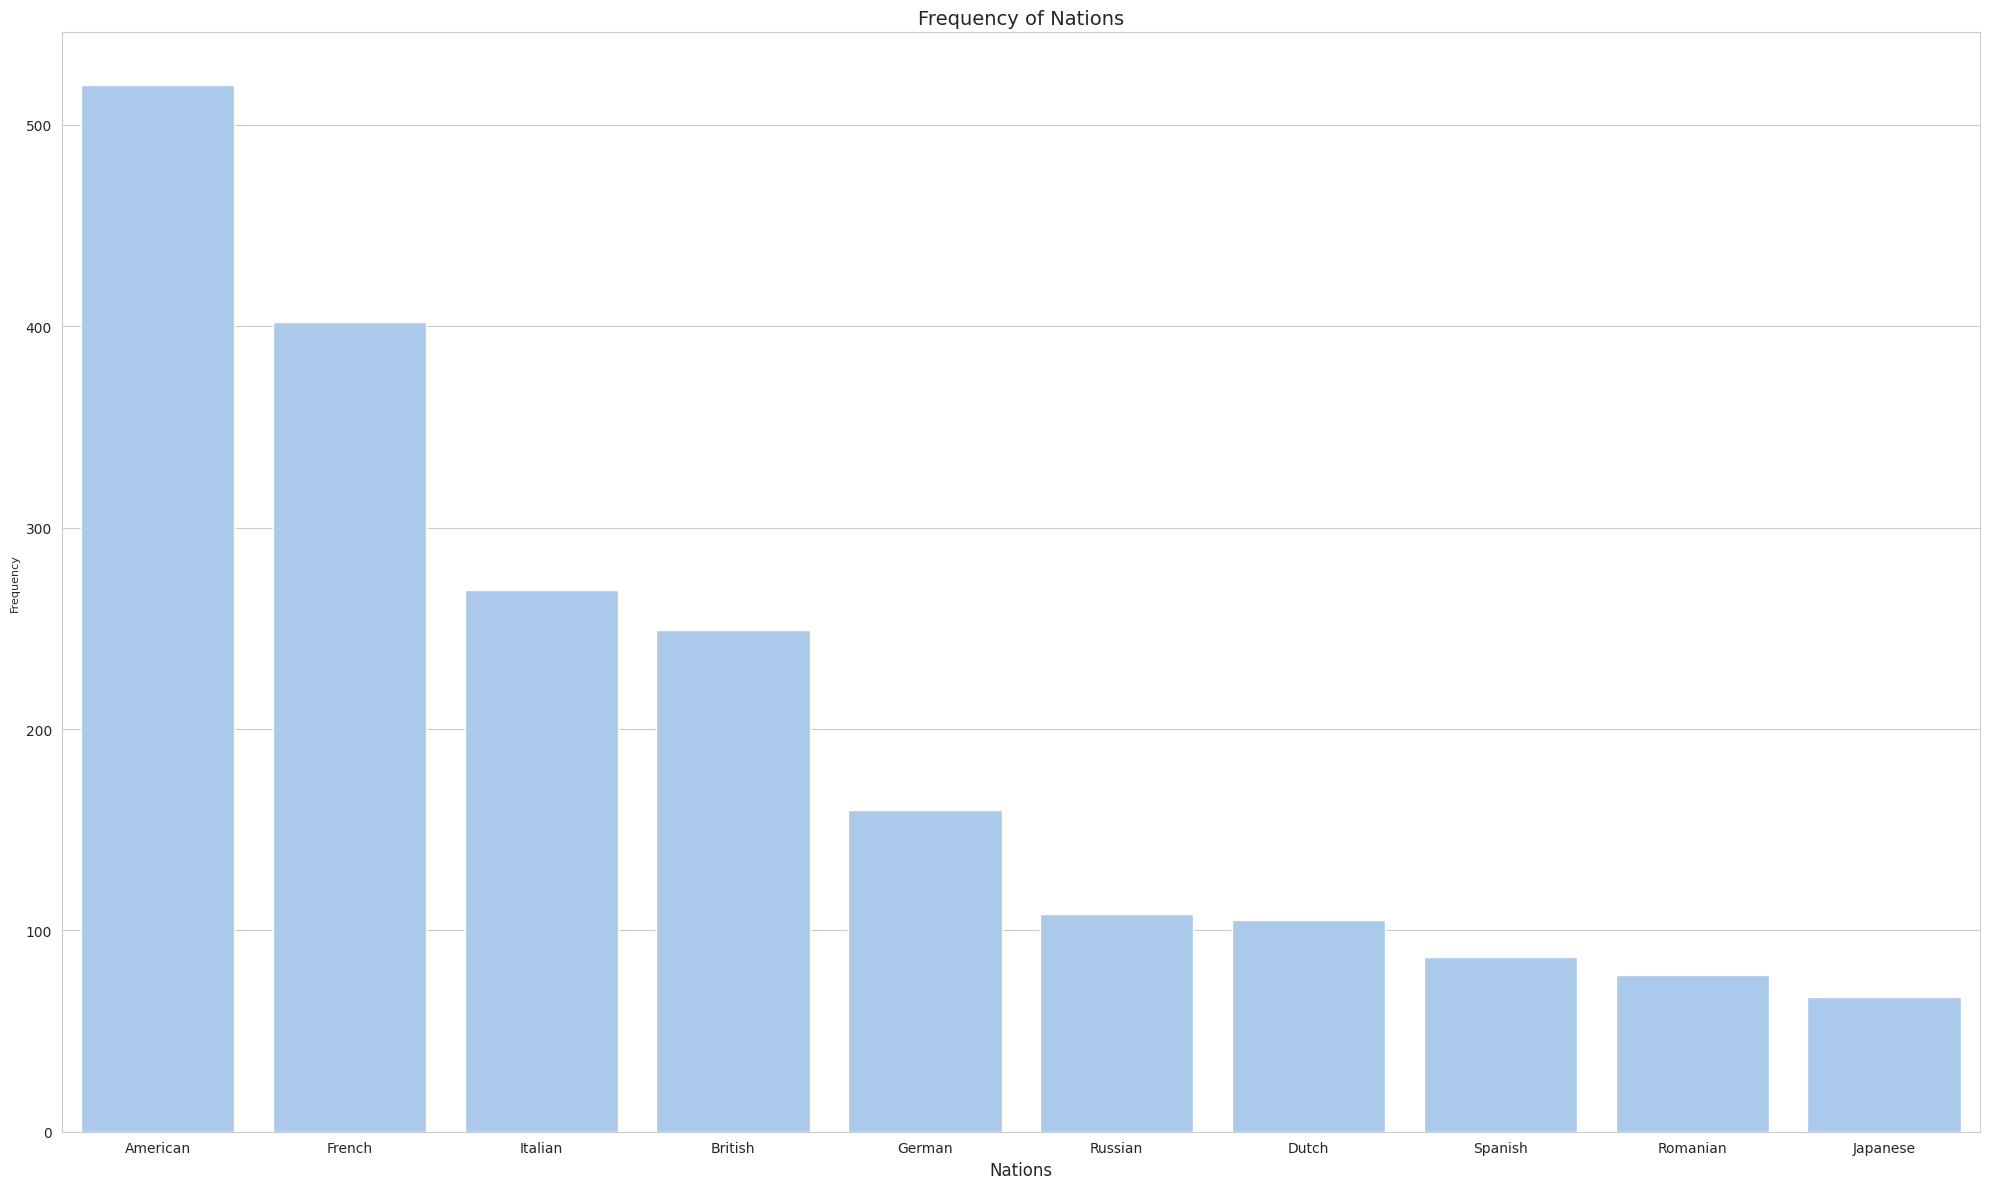

In [ ]:
nations = artists['nation'].value_counts()
print(nations)

sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(20, 12))
ax = sns.barplot(x=nations.index[:10], y=nations.values[:10])
plt.xlabel("Nations", fontsize=12)
plt.ylabel("Frequency", fontsize=8)
plt.title("Frequency of Nations", fontsize=14)
plt.tight_layout()
plt.show()

# 5) Which are the biggest communities in the network?  

In [ ]:
# 5 Community Detection (using friends' bidirectional edges only)
friends_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('relationship') == 'friend']
G_friends = G.edge_subgraph(friends_edges).to_undirected()
communities = list(nx.community.greedy_modularity_communities(G_friends))

print("\nTop 5 Largest Communities by Size:")
sorted_communities = sorted(communities, key=len, reverse=True)
for i, community in enumerate(sorted_communities[:5], start=1):
    print(f"Community {i} Size: {len(community)}")




Top 5 Largest Communities by Size:
Community 1 Size: 56
Community 2 Size: 34
Community 3 Size: 33
Community 4 Size: 21
Community 5 Size: 16


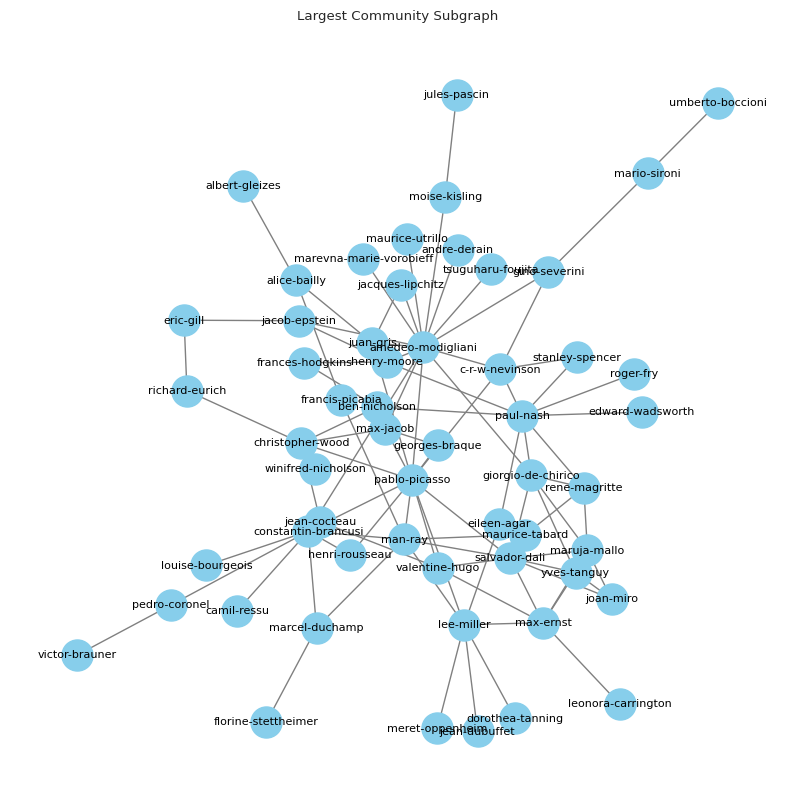

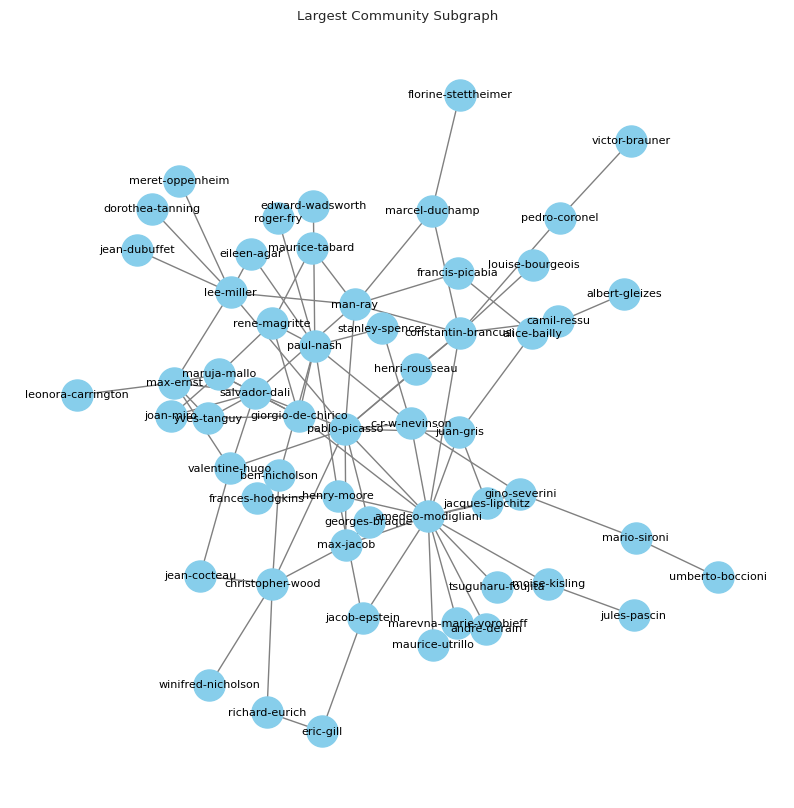

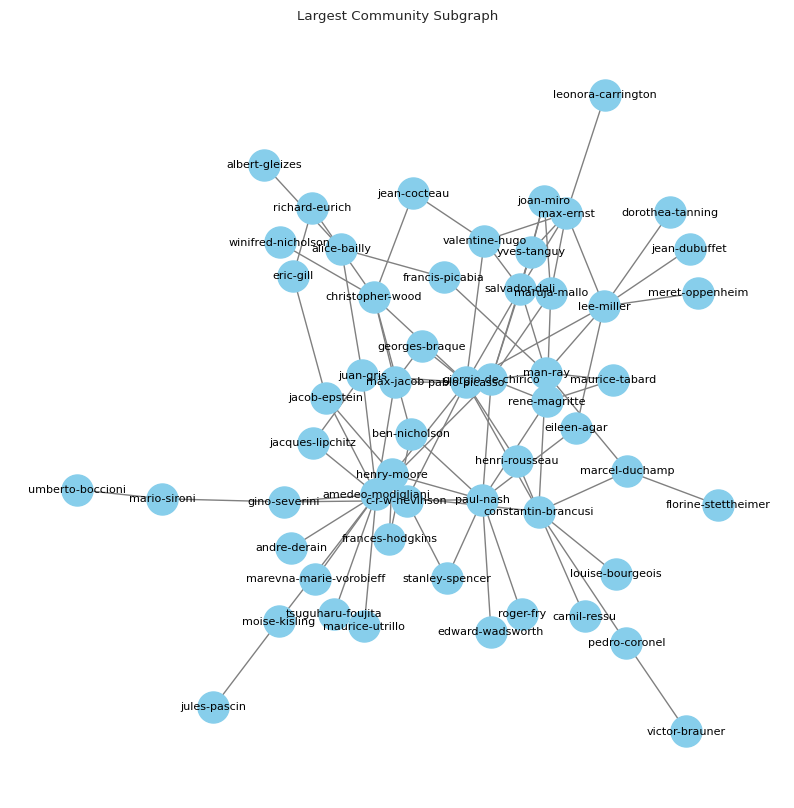

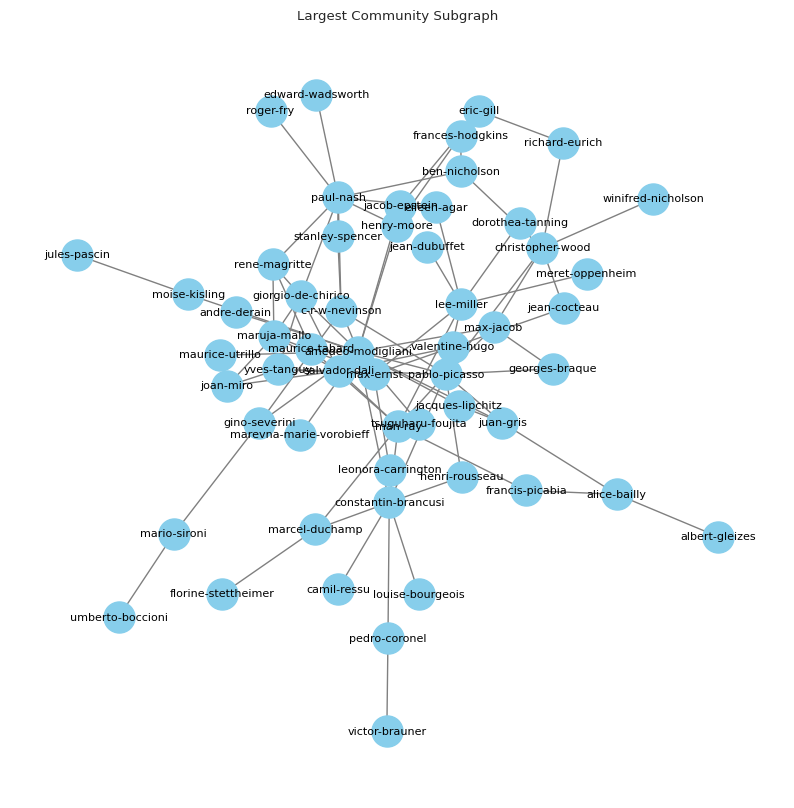

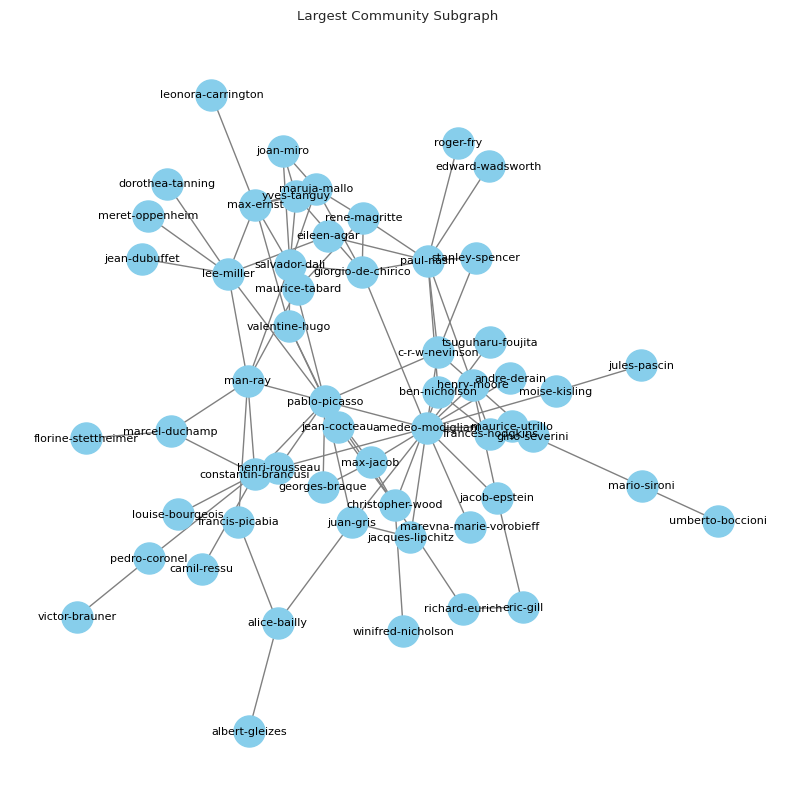

In [ ]:
#visualise the top 5 comminities
for community in sorted_communities[:5]:
  largest_community = sorted_communities[0]
  largest_community_graph = G.subgraph(largest_community).to_undirected()
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(largest_community_graph)
  nx.draw_networkx_labels(largest_community_graph, pos, font_size=8)
  nx.draw(largest_community_graph, pos, with_labels=False, node_size=500, node_color="skyblue", edge_color="gray")
  plt.title("Largest Community Subgraph")
  plt.show()

# Visualise the largest community

In [ ]:
#get input for the sorted community number from user
community_number = int(input("Enter the community number: "))
largest_community = sorted_communities[community_number-1]
largest_community_graph = G.subgraph(largest_community).to_undirected()

net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white", cdn_resources="in_line")
net.from_nx(largest_community_graph)
net.save_graph("artist_network.html")
with open("/content/artist_network.html", "r") as file:
    html_content = file.read()
display(HTML(html_content))


Enter the community number: 3
